In [10]:
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from matplotlib import cm
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'fantasy'
rcParams['font.fantasy'] = 'Arial'

#Характеристики материала
target_material_density = 120 # Плотность материала, кг/м3
target_material_porosity = 0.95 #пористость материала
pores_tortuosity = 11. # Извилистоть пор

a_parallelepiped = 10e-3 # длина плоскопараллельного тела, м
b_parallelepiped = 50e-3 # ширина плоскопараллельного тела, м
d_parallelepiped = 5e-3 # толщина плоскопараллельного тела, м

h_cylinder = 0.8 # Высота цилиндра, м 
d_cylinder = 0.0113 #Диаметр цилиндра геля, м  

d_sphere = 0.0125 #Диаметр сферы геля, м

#Характеристики аппарата высокого давления
d_apparatus = 320/1000 # диаметр аппарата, м
l_apparatus = 0.9 # длина аппарата, м
V_apparatus = math.pi / 4 * d_apparatus**2 * l_apparatus # Объем Аппарата, м3
S_apparatus = math.pi / 4 * d_apparatus**2 # площадь поперечного сечения аппарата, м2

#Шаги
h_n=100 #Количество шагов по координате
t_step_sec = 6 #Шаг по времени, с

#Физико-химические свойства веществ
Vmol = 22.4 #молярный объем, л/моль
Tc1 = 304.12 # Критическая температура диоксида углерода, K
Vc1 = 94.07 # Критический объем диоксида углерода, см3/моль
M1 = 44.01 # Молярная масса диоксида углерода, г/моль
M_TEOS = 208.33 #Молярная масса ТЭОС г/моль
M_IPS = 60.09 #Молярная масса ИПС г/моль
M_HCl = 36.46 #Молярная масса Соляная кислота г/моль
M_NH3 = 17.031 #Молярная масса Аммиак г/моль
M_H2O = 18.01528 #Молярная масса Вода г/моль

#ПОЛУЧЕНИЕ ГЕЛЕЙ
#Мольное соотношение ТЭОС:ИПС:0.01М Соляная кислота:0.1М Аммиак = 1:7:3.5:2.7
#Мольное соотношение чистых компонентов ТЭОС:ИПС:Соляная кислота:Аммиак = 1:7:0.000632432:0.004878762:6.194107854
#Мольное соотношение компонентов
ro_TEOS = 0.94 #Плотность ТЭОС г/мл
ro_IPS = 0.7851 #Плотность ИПС г/мл
ro_H2O = 0.997 #Плотность Вода г/мл

n_TEOS = 1 #Количество вещества ТЭОС моль
n_IPS = 7*n_TEOS #Количество вещества ИПС моль
n_0_01M_HCl = 3.5*n_TEOS #Количество вещества 0.01М Соляная кислота моль
n_0_1M_NH3 = 2.7*n_TEOS #Количество вещества 0.1М Аммиак моль
m_IPS = M_IPS*n_IPS #масса ИПС на получение гелей на заданное количество моль ТЭОС г
m_TEOS = M_TEOS*n_TEOS #масса ТЭОС г
m_0_01M_HCl = M_H2O*n_0_01M_HCl #масса 0.01М Соляная кислота г
m_0_1M_NH3 = M_H2O*n_0_1M_NH3 #масса 0.1М Аммиак г
m_gels = m_TEOS + m_IPS + m_0_01M_HCl + m_0_1M_NH3

#Массовые доли
w_TEOS = m_TEOS/m_gels 
w_IPS = m_IPS/m_gels 
w_0_01M_HCl = m_0_01M_HCl/m_gels 
w_0_1M_NH3 = m_0_1M_NH3/m_gels 

ro_gels = 1/(w_TEOS/ro_TEOS + w_IPS/ro_IPS + w_0_01M_HCl/ro_H2O + w_0_1M_NH3/ro_H2O) #Плотнсоть реакционной смеси гелей г/мл

V_gels_prep = m_gels/ro_gels

V_0_01M_HCl = m_0_01M_HCl / ro_H2O # Объем 0.01М Соляной кислоты, мл
V_0_1M_NH3 = m_0_1M_NH3 / ro_H2O # Объем 0.1М Аммиак, мл

Mol_HCl = 0.01 #Молярность Соляной кислоты
Mol_NH3 = 0.1 #Молярность Аммиак
n_HCl = Mol_HCl/1000*V_0_01M_HCl #Количество вещества Соляная кислота моль
n_NH3 = Mol_NH3/1000*V_0_1M_NH3 #Количество вещества Аммиак моль
n_H2O = n_0_01M_HCl + n_0_1M_NH3 - n_HCl - n_NH3 #Количество вещества Вода моль

C_HCl = 35 # Концентрация соляной кислоты по ГОСТ хч, %
C_NH3 = 25 # Концентрация аммиака по ГОСТ хч, %

m_HCl = n_HCl*M_HCl #масса Соляная кислота г
m_NH3 = n_NH3*M_NH3 #масса Аммиак г
m_35_HCl = m_HCl * 100/C_HCl #масса 35% Соляная кислота г
m_25_NH3 = m_NH3 * 100/C_NH3 #масса 25% Аммиак г
m_H2O = m_0_01M_HCl+m_0_1M_NH3-m_35_HCl-m_25_NH3#масса дист воды г

working_hours_year = 3*(365-14)*8 #Количество рабочих часов в год (351 дней по 24 часа в сутки - 3 смены), ч

cost_CO2_24kg = 8000 # Стоимость 1 моноблок 288 кг диоксида углерода, руб
cost_CO2_kg = cost_CO2_24kg/288 # Стоимость 1 кг диоксида углерода, руб/кг
cost_kw = 6.74098 #Стоимость 1 кВт*ч, руб

Fund = 14000000 #Объем капитальных вложений на аппарат объемом 70 л (основные фонды), руб (Ф)

#Постоянные расходы (S_п), руб/год - не зависят от объема выпускаемой продукции
Overhaul_year = Fund * 0.1 #Затраты на капитальные ремонты, руб/год (замена фитингов, фильтров, ремонт расходомера и подобное) (р)
Life_time = 10 #Срок службы основных фондов, год (Т)
Overhaul = Overhaul_year * Life_time  #Затраты на капитальные ремонты, руб/(срок службы) (Р)

Liquidation = 20000 #Ликвидационная стоимость основных фондов, руб/срок службы (Л)

Depreciation_rate = (Fund + Overhaul + Liquidation) / (Fund * Life_time) * 100 #Норма амортизации (Н_а)
Depreciation = Fund * Depreciation_rate / 100 #Амортизационные отчисления, руб/год (S_а)

Wage = 3500000 #Заработная плата, руб/год (S_о)

Scheduled_repair = Fund * 0.015 #Профилактический (плановый) ремонт, руб/год (замена прокладок, замена масла и пр.) (S_р)
Fixed_costs = Depreciation + Scheduled_repair + Wage # Постоянные расходы, руб/год (S_п)
#Постоянные расходы

#ПОЛУЧЕНИЕ ГЕЛЕЙ
#Стоимость сыря
#ТЭОС ОСОБО ЧИСТЫЙ 14-5 СТП ТУ КOMП 2-312-11
cost_TEOS = 170.4 # руб за кг
#Изопропиловый спирт (Пропанол-2), хч, фас бочка - от 200 л (160кг) цена за 1 кг
cost_IPS = 232 # руб за кг
#Соляная кислота, хч 1,2 кг, цена за 1 кг (Прекурсор, отпускается при соблюдении правил оборота)
cost_HCl = 110 # руб за кг
#Аммиак водный чда NH4OH в литре 0,9 кг, цена за 1л (97 руб)
cost_NH3 = 107.8 # руб за кг

"""#Затраты ИПС
#m_IPS
V_IPS_washing_replacing = V_gels_prep*4*4 #Объем ИПС на замену и отмывку заданного объема гелей, мл 
m_IPS_washing_replacing = V_IPS_washing_replacing * ro_IPS # масса ипс на замену и отмывку заданного объема гелей, г

#Возврат ИПС (Рецикл)
k_ips_rec = 0.9 # массовый коэффициент рецикла ИПС
k_shrink_gel = 0.95 # коэффициент объемной усдаки геля после замены растворителя и отмывки
m_IPS_rec_washing = m_IPS_washing_replacing * k_ips_rec # масса ипс на рецикл после замены и отмывки, г
m_IPS_rec_SCD = V_gels_prep* k_shrink_gel* target_material_porosity * ro_IPS  * k_ips_rec # масса ипс на рецикл после сепарации, г

#Итог потребления ИПС
m_ips_all = m_IPS + m_IPS_washing_replacing - m_IPS_rec_washing - m_IPS_rec_SCD

cost_gels = cost_TEOS* m_TEOS/1000 + cost_IPS * m_ips_all/1000 + cost_HCl * m_35_HCl/1000 + cost_NH3 * m_25_NH3/1000 #стоимость заданного объема гелей, руб
V_aerogel = V_gels_prep * k_shrink_gel * k_shrink_aerogel #Получаемый объем аэрогелей, мл
print(V_aerogel)
k_shrink_aerogel = 0.95 # коэффициент объемной усдаки аэрогеля после СКС
cost_1ml_gel = cost_gels/ V_aerogel #затраты реактивов на получение 1 мл аэрогеля, руб/мл 
C_1l_gel = cost_1ml_gel * 1000 #затраты реактивов на получение 1 л аэрогеля, руб/л
"""
k_ips_rec = 0.9 # массовый коэффициент рецикла ИПС
k_shrink_gel = 0.95 # коэффициент объемной усдаки геля после замены растворителя и отмывки
k_shrink_aerogel = 0.95 # коэффициент объемной усдаки аэрогеля после СКС
V_gels_1L = 1/(k_shrink_aerogel * k_shrink_gel) # объем гелей для получения 1 л аэрогеля, л/л

m_gels1L = V_gels_1L * ro_gels *1000 # Масса гелей для получения 1 л аэрогеля, г/л

m_IPS_1L = w_IPS*m_gels1L # Масса ИПС для получения 1 л аэрогеля, г/л

#Затраты ИПС
V_IPS_washing_replacing_1L = V_gels_1L*4*4 #Объем ИПС на замену и отмывку для получения 1 л аэрогеля, л/л
m_IPS_washing_replacing_1L = V_IPS_washing_replacing_1L * ro_IPS*1000 # масса ипс на замену и отмывку для получения 1 л аэрогеля, г/л
#Возврат ИПС (Рецикл)
m_IPS_rec_washing_1L = m_IPS_washing_replacing_1L * k_ips_rec # масса ипс после рецикла замены и отмывки для получения 1 л аэрогеля, г/л
m_IPS_before_rec_SCD_1L = V_gels_1L * k_shrink_gel* target_material_porosity * ro_IPS*1000 # масса ипс после рецикла после сепарации для
m_IPS_rec_SCD_1L = V_gels_1L * k_shrink_gel* target_material_porosity * ro_IPS*1000  * k_ips_rec # масса ипс до рецикла после сепарации для получения 1 л аэрогеля, г/л

#Итог потребления ИПС
m_ips_all_1L = m_IPS_1L + m_IPS_washing_replacing_1L - m_IPS_rec_washing_1L - m_IPS_rec_SCD_1L
"""print ('ИПС на получение геля, г/л', m_IPS_1L)
print ('ИПС на замену и отмывку, г/л', m_IPS_washing_replacing_1L)
print ('ИПС рецикл после замены и отмывки, г/л', m_IPS_rec_washing_1L)
print ('ИПС рецикл после СКС, г/л', m_IPS_rec_SCD_1L)
print ('Итоговые затраты ИПС, г/л', m_ips_all_1L)"""

m_TEOS_1L = w_TEOS*m_gels1L
m_35_HCl_1L = m_35_HCl*(m_TEOS_1L/m_TEOS)
m_25_NH3_1L = m_25_NH3*(m_TEOS_1L/m_TEOS)
m_H2O_1L=m_H2O*(m_TEOS_1L/m_TEOS)
C_gel_1L_TEOS = cost_TEOS* m_TEOS_1L/1000
C_gel_1L_IPS = cost_IPS * m_ips_all_1L/1000
C_gel_1L_HCl = cost_HCl * m_35_HCl_1L/1000
C_gel_1L_NH3 = cost_NH3 * m_25_NH3_1L/1000
C_gel_1L = C_gel_1L_TEOS + C_gel_1L_IPS + C_gel_1L_HCl + C_gel_1L_NH3
V_apparatus_l = V_apparatus*1000

def Fick(x):
# Расчет начальной концентрации ИПС
    reactor_load = x[0] #Загрузка реактора, об.%
    T = x[1]

    P = x[2]
    n_SCD = x[3]

    density_ips = 785.1
    V_gels = reactor_load / 100 * V_apparatus #
    V_gels_l = V_gels*1000


    a_parallelepiped = 10e-3 # длина плоскопараллельного тела, м
    b_parallelepiped = 50e-3 # ширина плоскопараллельного тела, м
    d_parallelepiped = 5e-3 # толщина плоскопараллельного тела, м

    h_cylinder = 0.8 # Высота цилиндра, м 
    d_cylinder = 0.0113 #Диаметр цилиндра геля, м  

    d_sphere = 0.0125 #Диаметр сферы геля, м

    v=1 # 0 - плоскопараллельное тело, 1 - цилиндрическое тело, 2 - сферическое тело 
    if v == 0:
        characteristic_size = d_parallelepiped / 2 #Характерестический размер, м
        S_gel = a_parallelepiped * d_parallelepiped # площадь поперечного сечения геля, м2
        V_gel = a_parallelepiped * b_parallelepiped * d_parallelepiped * monoliths_total #m3
    elif v == 1:
        characteristic_size = d_cylinder / 2
        S_gel = math.pi * characteristic_size ** 2 
        V_gel = math.pi * characteristic_size ** 2 * h_cylinder #m3
    elif v == 2:
        characteristic_size = d_sphere / 2
        S_gel = math.pi * characteristic_size ** 2
        V_gel = math.pi * 4/3 * characteristic_size**3 #m3
    h_step_meters = characteristic_size/h_n #Шаг по координате, м
    
    monoliths_total = V_gels/V_gel
    S_gels = S_gel * monoliths_total
    V_apparatus_free = V_apparatus - V_gels
    V_apparatus_taken = V_gels / V_apparatus * 100 #Объемная загрузка аппарата, %

    Np = monoliths_total / V_apparatus #Np, частиц/м3
    m_ips_additional = 0 #Масса дополнительного ИПС, г

    m_ips_gramms = V_gels * target_material_porosity * density_ips * 1000 + m_ips_additional

    c_ips = m_ips_gramms / (V_apparatus - V_gels * (1 - target_material_porosity)) / 1000 #Концентрация ИПС, кг/м3

    #Tyn-Calus коэффициент диффузии диоксида углерода в ИПС
    # Расчет вязкости ИПС по империческому уравнению
    a1 = 8.07652E+15
    a2 = 8.91648E+13
    a3 = -2.89429E+13
    a4 = 89749140000
    a5 = 230022.4
    dynamic_viscosity_ips=(a1+a2*P/10)/(a3+a4*T+a5*T**3+P/10)/1000000 # Результат в Па*с
    #Расчет вязкости диоксида углерода по империческому уравнению
    B1 = -1.146067e-1
    B2 =6.978380e-7
    B3 =3.976765e-10
    B4 =6.336120e-2
    B5 =-1.166119e-2
    B6 =7.142596e-4
    B7 =6.519333e-6
    B8 =-3.567559e-1
    B9 =3.180473e-2
    dynamic_viscosity_co2 = ((B1+B2*P+B3*P**2+B4*math.log1p(T)+B5*(math.log1p(T))**2+B6*(math.log1p(T))**3)
    /(1+B7*P+B8*math.log1p(T)+B9*(math.log1p(T))**2))/1000 #Результат в Па*с
    #Расчет плотности диоксида углерода по полиному (полином получен по уравнении регрессии из данных Пенга-Робинсона)
    density_co2=14258.88822-84.97903074*T+11.30377033*P+0.017974145*T*P+0.135119422*T**2-0.071358164*P**2-4.73474E-05*T**3+0.000110024*P**3
    Par1 = 44.8 # Парахора диоксида углерода
    Par2 = 164.4 # Парахора ИПС
    Vmol01 = 33.34430417 # Молярный объем диоксида углерода при норм температуре кипения, см3/моль
    Vmol02 = 81.22763891 # Молярный объем ИПС при норм температуре кипения, см3/моль
    D_coef_co2_ips = 8.93*10**(-12)*(Vmol01/Vmol02**2)**(1/6)*(Par2/Par1)**0.6*T/(dynamic_viscosity_ips*1000) #динамическую вязкость умножаем на 1000 чтобы были мПа*с
    
    #He–Yu коэффициент диффузии ИПС в диоксиде углерода

    k = Tc1*Vc1/(1000*M1)
    A = 14.882+5.908*k+2.0821*k**2

    Vmol1 = M1/density_co2*1000 # Молярный объем диоксида углерода при норм температуре кипения, см3/моль
    Vv1=Vmol1/Vc1
    D_coef_ips_co2 = A * 10**(-9)*(T/M_IPS)**0.5*math.exp(-0.3887/(Vv1-0.23))
    
    kinenamitc_viscosity_co2 = dynamic_viscosity_co2 / density_co2
    kinenamitc_viscosity_ips = dynamic_viscosity_ips / density_ips
    
    V_total = V_apparatus_free + V_gels * target_material_porosity #объем аппарата + объем пор, м3

    
    def f(x):
        numerator = abs(
            (V_apparatus_free + V_gels * target_material_porosity) *
            ((x / density_ips + (1 - x) / density_co2) ** -1) * x
            - (m_ips_gramms/1000)
        )

        return numerator / (m_ips_gramms/1000)

    y_start = optimize.golden(f, maxiter=10000) # массовая доля, кг/кгсм

    V_ips = density_co2 * y_start / (density_ips * (1 - y_start) + density_co2 * y_start) # объемная доля, м3/м3

    density_mixture = density_ips * V_ips + density_co2 * (1 - V_ips) # плотность смеси, кг/м3

    m_mixture = density_mixture * V_total # Масса смеси, кг

    m_ips = y_start * m_mixture # Масса спирта в смеси, кг

    m_aerogels = target_material_density * V_gels

    # МАССА ИПС В ГЕЛЕ, КГ

    h_arr = []
    V_cell = []

    h_arr.append(0)
    V_cell.append(0)
    for i in range(1,h_n+1):
        h_arr.append(characteristic_size / h_n + h_arr[i - 1])
        if v == 0:
            V_cell.append((h_arr[i]*2 - h_arr[i-1]*2) * target_material_porosity * a_parallelepiped * b_parallelepiped)
        elif v == 1:
            V_cell.append(math.pi * (h_arr[i]**2 - h_arr[i-1]**2) * target_material_porosity * h_cylinder)
        elif v == 2:
            V_cell.append(math.pi * 4/3 * (h_arr[i]**3 - h_arr[i-1]**3) * target_material_porosity )

    V_cell_sum = np.sum(V_cell)

    y_fick = []
    y_fick.append([y_start for i in range(0, h_n+1)])
    y_fick_center = []
    y_fick_center.append(y_start)
    
    y_fick_border = []
    y_fick_border.append(y_start)
    t_step_min = t_step_sec/60
    j = 12000/t_step_min
    
    t_step_index = 0

    m_alc_out = []
    m_ips_in_gels = []
    m_ips_in_gel = []
    ips_gel_load = []
    c_ips_free = []
    density_mixture_free = []
    m_ips_free = []
    m_ips_apparatus = []
    c_ips_apparatus_percent = []
    c_ips_gels_percent = []
    M_ips_free = []
    D_coef_mol_free = []
    kinenamitc_viscosity_mixture_free = []
    Sc = []
    U = []
    Re = []
    Sh_turbulent = []
    Sh_lam = []
    Sh = []
    mass_transfer_coef = []
    c_ips_gel_border = []
    M_ips_in_gel = [] #Мольная доля
    M_co2_ratio_in_gel_center = [] #Мольная доля
    D_coef_mol_in_gel = []

    dif_m_ips_free = [] #динамика по изменеию массы спирта в свободном объеме аппарата
    delta_dif_m_ips_free = [] #изменение динамики
    m_alc_out.append(0)

    time_scale = []
    w = []
    CO2_flow = []
    mass_co2_step = []
                 
    for t_step_index in range(0, round (j)):

        time_scale.append(t_step_sec * t_step_index)

        #Количество этапов СКС n_SCD
        if n_SCD ==1:
            co2_rate_g_hour_start = x[4]
            co2_rate_m3_sec_start =co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==2:
            time_I = x[4] #Продолжительность 1 этапа
            co2_rate_g_hour_start = x[5]
            co2_rate_g_hour_2 = x[6]
            if time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==3:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            co2_rate_g_hour_start = x[6]
            co2_rate_g_hour_2 = x[7]
            co2_rate_g_hour_3 = x[8]
            if time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==4:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            time_III = x[6] #Продолжительность 3 этапа
            co2_rate_g_hour_start = x[7]
            co2_rate_g_hour_2 = x[8]
            co2_rate_g_hour_3 = x[9]
            co2_rate_g_hour_4 = x[10]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==5:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            time_III = x[6] #Продолжительность 3 этапа
            time_IV = x[7] #Продолжительность 4 этапа
            co2_rate_g_hour_start = x[8]
            co2_rate_g_hour_2 = x[9]
            co2_rate_g_hour_3 = x[10]
            co2_rate_g_hour_4 = x[11]
            co2_rate_g_hour_5 = x[12]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV:
                co2_rate_m3_sec_start = co2_rate_g_hour_5 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==12:
            time_I = x[3] #Продолжительность 1 этапа
            time_II = x[4] #Продолжительность 2 этапа
            time_III = x[5] #Продолжительность 3 этапа
            time_IV = x[6] #Продолжительность 4 этапа
            time_V = x[7] #Продолжительность 5 этапа
            time_VI = x[8] #Продолжительность 6 этапа
            time_VII = x[9] #Продолжительность 7 этапа
            time_VIII = x[10] #Продолжительность 8 этапа
            time_IX = x[11] #Продолжительность 9 этапа
            time_X = x[12] #Продолжительность 10 этапа
            time_XI = x[13] #Продолжительность 11 этапа

            co2_rate_g_hour_start = x[14]
            co2_rate_g_hour_2 = x[15]
            co2_rate_g_hour_3 = x[16]
            co2_rate_g_hour_4 = x[17]
            co2_rate_g_hour_5 = x[18]
            co2_rate_g_hour_6 = x[19]
            co2_rate_g_hour_7 = x[20]
            co2_rate_g_hour_8 = x[21]
            co2_rate_g_hour_9 = x[22]
            co2_rate_g_hour_10 = x[23]
            co2_rate_g_hour_11 = x[24]
            co2_rate_g_hour_12 = x[25]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX+time_X+time_XI:
                co2_rate_m3_sec_start = co2_rate_g_hour_12 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX+time_X:
                co2_rate_m3_sec_start = co2_rate_g_hour_11 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX:
                co2_rate_m3_sec_start = co2_rate_g_hour_10 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII:
                co2_rate_m3_sec_start = co2_rate_g_hour_9 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII:
                co2_rate_m3_sec_start = co2_rate_g_hour_8 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI:
                co2_rate_m3_sec_start = co2_rate_g_hour_7 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V:
                co2_rate_m3_sec_start = co2_rate_g_hour_6 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV:
                co2_rate_m3_sec_start = co2_rate_g_hour_5 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2

        CO2_flow.append(co2_rate_m3_sec_start*1000*3600*density_co2)
        mass_co2_step.append(CO2_flow[t_step_index]*6/3600)         
        if t_step_index > 0:


            c_coef = [None] * (h_n + 1)
            a_coef = [None] * (h_n + 1)
            b_coef = [None] * (h_n + 1)
            alfa = [1] * (h_n + 1)
            beta = [0] * (h_n + 1)

            y_fick.append([None] * (h_n + 1))
            y_fick[t_step_index][h_n] = c_ips_gel_border[t_step_index]

            for i in range (1,h_n):

                c_coef[i] = (D_coef_mol_in_gel[t_step_index-1][i]+D_coef_mol_in_gel[t_step_index-1][i-1])*target_material_porosity/pores_tortuosity/2 *((h_arr[i]**v+h_arr[i-1]**v)/2) / (h_step_meters**2*h_arr[i]**v)
                a_coef[i] = (D_coef_mol_in_gel[t_step_index-1][i]+D_coef_mol_in_gel[t_step_index-1][i+1])*target_material_porosity/pores_tortuosity/2 *((h_arr[i]**v+h_arr[i+1]**v)/2) / (h_step_meters**2*h_arr[i]**v)
                b_coef[i] = 1 / t_step_sec + a_coef[i] + c_coef[i]
                alfa[i] = a_coef[i] / (b_coef[i] - alfa[i-1] * c_coef[i])
                beta[i] = (beta[i-1] * c_coef[i] + y_fick[t_step_index-1][i] / t_step_sec) / (b_coef[i] - alfa[i-1] * c_coef[i])

            for i in range(h_n-1, 0, -1):

                y_fick[t_step_index][i] = alfa[i] * y_fick[t_step_index][i+1] + beta[i]

            y_fick[t_step_index][0] =  y_fick[t_step_index][1]

        M_ips_in_gel.append([M1/1000 * y_fick[t_step_index][i] / ((1-y_fick[t_step_index][i]) * M_IPS/1000 + y_fick[t_step_index][i] * M1/1000) for i in range(0,h_n+1)])

        D_coef_mol_in_gel.append([D_coef_co2_ips ** M_ips_in_gel[t_step_index][i] * D_coef_ips_co2 ** (1 - M_ips_in_gel[t_step_index][i]) for i in range(0,h_n+1)])

        matrix_ips = [y_fick[t_step_index][i] * V_cell[i] * density_co2  for i in range(0, h_n+1)]

        M_co2_ratio_in_gel_center.append(1 - M_ips_in_gel[t_step_index][0])


        m_ips_in_gel.append(np.sum(matrix_ips))


        m_alc_out.append((m_ips_in_gel[t_step_index-1] - m_ips_in_gel[t_step_index]) * monoliths_total if t_step_index > 0 else 0)

        m_ips_in_gels.append(m_ips_in_gels[t_step_index - 1] - m_alc_out[t_step_index] * 1000 if t_step_index > 0 else (V_cell_sum * monoliths_total) * y_start * density_mixture * 1000)

        ips_gel_load.append(m_ips_in_gel[t_step_index] / (m_ips_in_gel[t_step_index] + target_material_density * V_gels / monoliths_total) * 100)


        c_ips_free.append(
            c_ips_free[t_step_index - 1] *
            (1 - t_step_sec / (V_apparatus_free / co2_rate_m3_sec_start)) +
            m_alc_out[t_step_index] / V_apparatus_free / density_co2
            if t_step_index > 0 else y_start
        )


        m_ips_free.append(c_ips_free[t_step_index] * V_apparatus_free * 1000 * density_co2)
        
        #Расчет динамики в свободном объеме аппарата
        #dif_m_ips_free.append = (m_ips_free[-1]-m_ips_free[0])/t_step_sec

        m_ips_apparatus.append(m_ips_free[t_step_index] + m_ips_in_gels[t_step_index])


        c_ips_apparatus_percent.append(m_ips_apparatus[t_step_index] / m_ips_apparatus[0] * 100)


        c_ips_gels_percent.append(m_ips_apparatus[t_step_index] / (m_ips_apparatus[t_step_index] + m_aerogels * 1000) * 100)



        M_ips_free.append(M1/1000* c_ips_free[t_step_index] / ((1 - c_ips_free[t_step_index]) * M_IPS/1000 + M1/1000 * c_ips_free[t_step_index]))



        D_coef_mol_free.append(D_coef_co2_ips ** M_ips_free[t_step_index] * D_coef_ips_co2**(1 - M_ips_free[t_step_index]))


        kinenamitc_viscosity_mixture_free.append(kinenamitc_viscosity_co2 ** (1 - M_ips_free[t_step_index]) * kinenamitc_viscosity_ips ** M_ips_free[t_step_index])


        Sc.append(kinenamitc_viscosity_mixture_free[t_step_index] / D_coef_mol_free[t_step_index])

        U.append(co2_rate_m3_sec_start / (S_apparatus - S_gel)) # Средняя поверхностная скорость потока в центре аппарата

        Re.append(math.pi * characteristic_size * U[t_step_index] / kinenamitc_viscosity_mixture_free[t_step_index])


        Sh_turbulent.append(
            0.037 * (Re[t_step_index]**0.8) * Sc[t_step_index]
            /
            (1 +
            2.443 * (Re[t_step_index] ** (-0.1))
            *
            (Sc[t_step_index] ** (2/3) - 1))
        ) # TODO: check it!!


        Sh_lam.append(0.664 * Re[t_step_index] ** 0.5 * Sc[t_step_index] ** 1.5)


        Sh.append(0.3 + (Sh_lam[t_step_index]**2 + Sh_turbulent[t_step_index] ** 2) ** 0.5)

        mass_transfer_coef.append(D_coef_mol_free[t_step_index] * Sh[t_step_index] * 0.805 / (math.pi * characteristic_size))


        if t_step_index == 0:
            c_ips_gel_border.append(c_ips_free[t_step_index])

        # adding for n+1 time step

        c_ips_gel_border.append(

                (
                    target_material_porosity * D_coef_mol_in_gel[t_step_index][h_n] * y_fick[t_step_index][h_n-1] / (pores_tortuosity * (h_arr[h_n] - h_arr[h_n-1])) +
                    mass_transfer_coef[t_step_index] * c_ips_free[t_step_index]                   
                ) /
                ( target_material_porosity * D_coef_mol_in_gel[t_step_index][h_n] / (pores_tortuosity*(h_arr[h_n] - h_arr[h_n-1])) +
                mass_transfer_coef[t_step_index])
            )

        Mn = np.sum([y_fick[t_step_index][i] * density_co2 * V_cell[i] * target_material_porosity  for i in range(0,h_n+1)])
    
        
        w.append(Mn / (Mn + target_material_density * V_gels/monoliths_total) * 100)
        y_fick_border.append(y_fick[t_step_index][-1])
        y_fick_center.append(y_fick[t_step_index][0])
        x_fick_finish = M1/1000 * y_fick[t_step_index][0] / ((1-y_fick[t_step_index][0])*M_IPS/1000 + y_fick[t_step_index][0] * M1/1000)
        if w[t_step_index] < 0.045:
            break                 
        """if x_fick_finish < 1 - (-0.00000566 * T**2 + 0.00297872 * T + 0.61188008):
            break""" # условие остановки СКС по мольной доли ИПС по фазовым диаграммам в зависимости от температуры
    y_fick_border.pop(0)
    y_fick_center.pop(0)
    time_procces = time_scale[-1]/60
    Mass_CO2 = sum(mass_co2_step)+V_apparatus/2*density_co2*1000
    time_scale_min = [val / 60 for val in time_scale]
    
    Prepare_time = 4 # герметизация, загрузка, выгрузка аппарата и сброс давления, ч
    N_SCD = working_hours_year / (time_procces/60 + Prepare_time) # Количество циклов СКС за год
    
    prod_aerogels = V_gels_l*k_shrink_gel*k_shrink_aerogel * N_SCD  #Производительность установки по аэрогелю, л/год
    prod_gels =  V_gels_l* N_SCD  #Геля, л/год
    prod_gels_w_r = V_gels_l*k_shrink_gel* N_SCD
    waste = (prod_gels - prod_gels_w_r) * ro_gels/1000
    #Постоянные расходы
    F_costs = Fixed_costs / prod_aerogels # Постоянные расходы, руб/л (s_п)

    #Затраты на диоксид углерода
    Mass_CO2_all = Mass_CO2/1000000 * N_SCD
    k_CO2 = .85
    Mass_CO2_rec = Mass_CO2_all*k_CO2
    Mass_CO2_input =  Mass_CO2_all - Mass_CO2_rec # Затраты на диоксид углерода, т/год
    Carbon_dioxide_costs = Mass_CO2_input*1000 * cost_CO2_kg  # Затраты на диоксид углерода, руб/год 
    CO2_costs = Carbon_dioxide_costs / prod_aerogels # Затраты на диоксид углерода, руб/л

    #Стоимость сыря на получение геля

    cost_1l_gel = C_gel_1L * prod_aerogels #стоимость геля, руб/год
    Mm_ips_all = m_ips_all_1L * prod_aerogels/1000000 #стоимость геля, руб/год
    Mm_IPS=m_IPS_1L* prod_aerogels/1000000
    Mm_IPS_washing_replacing=m_IPS_washing_replacing_1L* prod_aerogels/1000000
    Mm_IPS_rec_washing=m_IPS_rec_washing_1L* prod_aerogels/1000000
    Mm_IPS_rec_SCD=m_IPS_rec_SCD_1L* prod_aerogels/1000000
    Mm_TEOS=m_TEOS_1L* prod_aerogels/1000000
    Mm_35_HCl=m_35_HCl_1L* prod_aerogels/1000000
    Mm_25_NH3=m_25_NH3_1L* prod_aerogels/1000000
    Mm_H2O = m_H2O_1L* prod_aerogels/1000000
    Mm_IPS_before_rec_SCD_1L = m_IPS_before_rec_SCD_1L* prod_aerogels/1000000

    #Затраты на элеткроэнергию
    #Охлаждение диоксида углерода с 94 С до 5 С
    delta_H_cold = 322 #кДж/кг
    Eff_cold = 0.85 # КПД системы охлаждения
    Q_cold = delta_H_cold * (Mass_CO2/(time_procces*1000))/60 / Eff_cold # необходимая мощность системы охлаждения, кВт
    
    #Нагнетание давление насосом с 40 бар до 150 бар (берем среднее, значительных измененией не будет)
    delta_H_pump = 11 #кДж/кг
    Eff_pump = 0.35 # КПД насоса
    Q_pump = delta_H_pump * (Mass_CO2/(time_procces*1000)/60) / Eff_pump   # необходимая мощность насосной станции, кВт
    #Нагрев диоксида углерода до температуры перед дросселированием, тут идет сумма нагрева до аппарата и после аппарата, так как эта сумма не будет зависеть от температуры процесса и практически не будет зависеть от давления процесса
    delta_H_heat = 67+168 #кДж/кг
    Eff_heat = 0.85 # КПД системы нагрева
    Q_heat = delta_H_heat * (Mass_CO2/(time_procces*1000))/60 / Eff_heat   # необходимая мощность системы нагрева, кВт
    #Нагнетание давление компрессором с 10 бар до 40 бар (берем среднее, значительных измененией не будет)
    delta_H_compr = 76 #кДж/кг
    Eff_compr = 0.7 # КПД компрессора
    Q_compr = delta_H_pump * (Mass_CO2/(time_procces*1000))/60 / Eff_compr   # необходимая мощность насосной станции, кВт
    
    Power = Q_cold + Q_pump + Q_heat + Q_compr # Общая потребляемая мощность установки СКС, кВт
    #print("Потребляемая мощномть установки =",Power, "кВт")
    kw_hr = Power * working_hours_year # потребление энергии за год, кВт*ч
    Electr_costs = cost_kw * kw_hr # Затраты на электроэнергию, руб/год
    E_costs = Electr_costs / prod_aerogels # Затраты на электроэнергию, руб/л

    #Себестоимость аэрогеля
    Cost_aerogel = Fixed_costs + cost_1l_gel + Electr_costs + Carbon_dioxide_costs # Себестоимость аэрогеля, руб/год
    #print ("Себестоимость аэрогеля =",Cost_aerogel, "руб/год")
    C_aerogel = F_costs + C_gel_1L + E_costs + CO2_costs # Себестоимость аэрогеля, руб/л
    
    #Цена аэрогеля S_ц
    Pc_aerogel = 10000 # Цена аэрогеля, руб/л
    Price_aerogel = Pc_aerogel*prod_aerogels# Цена аэрогеля, руб/год
    Profit = Price_aerogel - Cost_aerogel #Прибыль, руб/год
    Prof_rate = (Pc_aerogel-C_aerogel)/C_aerogel*100 #Норма прибыли
    Profitability_rate = (Price_aerogel-Cost_aerogel)/Fund #Норма рентабельности

    #_df = pd.DataFrame(w)
    #print(w_df)
    """fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot() 
    plt.plot(time_scale_min, y_fick_center, label='Концентраяция ИПС в центре геля')
    plt.plot(time_scale_min, y_fick_border, label='Концентрация ИПС на границе геля')
    plt.grid(True)
    plt.legend()
    ax.set_xlabel("Время, мин", fontsize=20)"""
    """print('Масса диоксида углерода за один цикл сушки', Mass_CO2)
    print('Гель после получения, л/год',prod_gels)
    print('т/год',prod_gels* ro_gels/1000)
    print('Гель после отмывки и замены, л/год',prod_gels_w_r)
    print('т/год',prod_gels_w_r* ro_gels/1000)
    print('Отходы после отмывки, т/год',waste)
    print('Масса подмеса диоксида углерода, т/год', Mass_CO2_input)
    print('Масса рецикла диоксида углерода, т/год', Mass_CO2_rec)
    print ('ИПС на получение геля, т/год', Mm_IPS)
    print ('ИПС на замену и отмывку, т/год', Mm_IPS_washing_replacing)
    print ('ИПС рецикл после замены и отмывки, т/год', Mm_IPS_rec_washing)
    print ('ИПС до рецикла ИПС после СКС, т/год', Mm_IPS_before_rec_SCD_1L)
    print ('ИПС рецикл после СКС, т/год', Mm_IPS_rec_SCD)
    print ('Итоговые затраты ИПС, т/год', Mm_ips_all)
    print ('ТЭОС, т/год', Mm_TEOS)
    print ('35 % раствор соляной кислоты, т/год', Mm_35_HCl)
    print ('25 % раствор аммиака, т/год', Mm_25_NH3)
    print ('Дистиллированная вода, т/год', Mm_H2O)
    print ("Себестоимость аэрогеля =",C_aerogel, "руб/л")
    print ("Производительность установки по аэрогелю =", prod_aerogels, "л/год")
    print ('т/год', prod_aerogels/1000*target_material_density/1000)
    print ("Количество циклов СКС за год =",N_SCD)
    print ("Постоянные расходы =", F_costs, "руб/л аэрогеля") 
    print ("Постоянные расходы =", Fixed_costs, "руб/год")      
    print ("Затраты на электроэнергию =",E_costs, "руб/л аэрогеля")
    print ("Затраты на электроэнергию =",Electr_costs, "руб/год")
    print ("Затраты на диоксид углерода =",Carbon_dioxide_costs, "руб/год")
    print ("Затраты на диоксид углерода =",CO2_costs, "руб/л аэрогеля")
    print ("Затраты на сырье для получения геля =",cost_1l_gel, "руб/год")
    print ("Затраты на сырье для получения геля =",C_gel_1L, "руб/л аэрогеля")"""
    """fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()
    xxx = [0,605.2]
    yyy = [150000, 150000]
    plt.plot(xxx, yyy,color = 'green', linewidth = 7, label = 'Реальное производство')
    plt.plot(time_scale_min, CO2_flow,color = 'black', linewidth = 7, label ='Результат оптимизации')
    plt.grid(False)
    plt.legend (loc = 3, fontsize=32)
    ax.set_xlabel("t, мин", fontsize=36)
    ax.set_ylabel("Расход CO$_{2}$, кг/ч", fontsize=36)
    
    xticks = ax.get_xticks()

    xx = np.arange(0, 601, 60)
    xlabels = []
    for i in xx:
        xlabels.append('%d' % i)
    ax.set_xticks(xx)
    ax.set_xticklabels(xlabels, fontsize=36)

    yticks = ax.get_yticks()   
    yy = np.arange(0, 150001, 30000)
    ylabels = []
    for i in yy:
        ylabels.append('%d' % i)
    ax.set_yticks(yy)
    ax.set_yticklabels(yy, fontsize=36)
    plt.show()"""

    """fig = plt.figure(figsize = (25, 15))
    ax = fig.add_subplot()
    ax.set_title("Составляющие себестоимости", fontsize=48) # Составляющие себестоимости Self-cost

    data = [
        ["Амортизация", Depreciation], # Амортизация Depreciation
        ["Заработная плата", Wage], # Заработная плата Labour cost
        ["Профилактический ремонт", Scheduled_repair], # Профилактический ремонт Schedule maintenance
        ["Электроэнергия", Electr_costs], # Электроэнергия Electricity bill
        ["Сырье на гель", cost_1l_gel], # Сырье на гель Gel raw material costs
        ["Диоксид углерода", Carbon_dioxide_costs] # Диоксид углерода Cost of carbon dioxide
    ]

    values = [x[1] for x in data]
    labels = [x[0] for x in data]
    explode = [0.025,0.025,0.025,0.025,0.05,0.025]
    colors = ['black', 'sienna','yellow','red','blue', 'green']
    ax.pie(values,colors=colors, radius= 1.2, explode = explode,counterclock = False, startangle = 90, shadow = True)
    ax.set_aspect("equal")

    # Decoration
    ax.legend(labels, loc="center left", bbox_to_anchor=(0.8, 0.2, 0, 1), fontsize=28)
    fig.savefig('pie.png')"""

    return(C_aerogel)
#print (Fick([8.00000000e+01, 3.39000000e+02, 1.20000000e+02, 2.00000000e+00, 1, 1.41314916e+05, 100000]))
print (Fick([70, 313, 120, 1, 150000]))
"""print (Fick([80, 338, 120, 1, 50000]))
print (Fick([80, 338, 120, 1, 70000]))
print (Fick([80, 338, 120, 1, 90000]))
print (Fick([80, 338, 120, 1, 110000]))
print (Fick([80, 338, 120, 1, 130000]))
print (Fick([80, 338, 120, 1, 150000]))"""
#print (Fick([80, 339, 120, 1, 6.90664592e+04])) # оптимальный расход 6.90664592e+04 для 120 бар и 339 K 
#print (Fick([8.00000000e+01, 3.39000000e+02, 1.20000000e+02, 2.00000000e+00, 6.60700427e+00, 1.41314916e+05, 6.75762265e+04]))# оптимальный расход 2 этапа СКС для 120 бар и 313 K 
#print (Fick([8.00000000e+01, 3.39000000e+02, 1.20000000e+02, 5.00000000e+00, 5.38329540e-01, 9.66493859e+00, 2.42056502e+01, 1.79792426e+02,9.53555244e+04, 1.30157801e+05, 7.19072461e+04, 4.98592624e+04, 4.99571946e+04])) # оптимальный расход 5 этапов СКС для 120 бар и 313 K
#print (Fick([80, 339, 120, 4, 24, 80, 147,141000, 68000, 58900, 51000]))
#print (Fick([80,339,120,4,11.344,239,238.7,140791,66282,59787,47301]))

#Объемная загрузка гелей, Температура, давление, количество этапов 5, продолжительность 1 этапа, продолжительность 2 этапа, продолжительность 3 этапа, продолжительность 4 этапа, расход на 1 этапе, расход на 2 этапе, расход на 3 этапе, расход на 4 этапе, расход на 5 этапе
#print (Fick([55, 313, 120, 5, 60, 60, 60, 60, 150000, 100000, 50000, 25000, 12500]))
#print (Fick([8.00000000e+01, 3.39000000e+02, 1.20000000e+02, 5.00000000e+00, 9.79783990e+00, 1.34102004e+02, 1.46571883e+02, 1.73862169e+02, 1.38838115e+05, 6.04476667e+04, 6.80756350e+04, 7.40708039e+04, 9.56239760e+04]))

768.5032954290816


'print (Fick([80, 338, 120, 1, 50000]))\nprint (Fick([80, 338, 120, 1, 70000]))\nprint (Fick([80, 338, 120, 1, 90000]))\nprint (Fick([80, 338, 120, 1, 110000]))\nprint (Fick([80, 338, 120, 1, 130000]))\nprint (Fick([80, 338, 120, 1, 150000]))'

In [2]:
#ОПТИМИЗАЦИЯ
from scipy.optimize import minimize 
n_SCD = 2
def inequality_constraint(x):
    T = x[0]
    P = x[1]

    return P+0.0049*T**2-4.2111*T + 754.56 #P+0.0049*T**2-4.2111*T > - 754.56
constraint = {'type': 'ineq', 'fun': inequality_constraint}
if n_SCD == 1:
    bounds_load = (60, 80)
    bounds_T = (313, 339)
    bounds_P = (120, 120)
    bounds_n_SCD = (1,1)
    bounds_co2_rate_g_hour_start = (10000, 150000)

    bounds = [bounds_load, bounds_T, bounds_P, bounds_n_SCD, bounds_co2_rate_g_hour_start]
    
    x0 = ([70,313,120, 1, 60000])

    res = minimize(Fick, x0, method='powell', bounds = bounds, options={'xtol': 1e-2, 'disp': True})
    #res = minimize(Fick, x0, method='SLSQP', bounds=bounds, constraints= constraint, options={'xtol': 1e-2, 'disp': True})
    print (res.x)

elif n_SCD == 2:

    bounds_load = (80, 80)
    bounds_T = (339, 339)
    bounds_P = (120, 120)
    bounds_n_SCD = (2,2)
    bounds_time_I = (0, 120)
    bounds_co2_rate_g_hour_start = (10000, 150001)
    bounds_co2_rate_g_hour_2 = (10000, 150001)

    bounds = [bounds_load, bounds_T, bounds_P, bounds_n_SCD, bounds_time_I, bounds_co2_rate_g_hour_start, bounds_co2_rate_g_hour_2]

    x0 = ([80,339, 120, 2, 120, 10000, 10000])
    res = minimize(Fick, x0, method='powell', bounds = bounds, options={'xtol': 1e-2, 'disp': True})
    #res = minimize(Fick, x0, method='SLSQP', bounds=bounds, constraints= constraint, options={'xtol': 1e-2, 'disp': True})
    print (res.x)

elif n_SCD ==4:
    bounds_load = (80, 80)
    bounds_T = (339, 339)
    bounds_P = (120, 120)
    bounds_n_SCD = (4,4)
    bounds_time_I = (10, 180)
    bounds_time_II = (0, 240)
    bounds_time_III = (0, 240)
    bounds_co2_rate_g_hour_start = (120000, 150000)
    bounds_co2_rate_g_hour_2 = (30000, 70000)
    bounds_co2_rate_g_hour_3 = (20000, 60000)
    bounds_co2_rate_g_hour_4 = (10000, 50000)
    bounds = [bounds_load, bounds_T, bounds_P, bounds_n_SCD, bounds_time_I,bounds_time_II,bounds_time_III, bounds_co2_rate_g_hour_start, bounds_co2_rate_g_hour_2, bounds_co2_rate_g_hour_3, bounds_co2_rate_g_hour_4]

    x0 = ([80,339, 120,4, 20, 60,60, 141000, 70000, 60000, 50000])
    res = minimize(Fick, x0, method='powell', bounds = bounds, options={'xtol': 1e-2, 'disp': True})
    print (res.x)

elif n_SCD ==5:
    bounds_load = (80, 80)
    bounds_T = (339, 339)
    bounds_P = (120, 120)
    bounds_n_SCD = (5,5)
    bounds_time_I = (5, 180)
    bounds_time_II = (0, 180)
    bounds_time_III = (0, 180)
    bounds_time_IV = (0, 180)
    bounds_co2_rate_g_hour_start = (100000, 150000)
    bounds_co2_rate_g_hour_2 = (10000, 150000)
    bounds_co2_rate_g_hour_3 = (10000, 150000)
    bounds_co2_rate_g_hour_4 = (5000, 150000)
    bounds_co2_rate_g_hour_5 = (5000, 150000)
    bounds = [bounds_load, bounds_T, bounds_P, bounds_n_SCD, bounds_time_I,bounds_time_II,bounds_time_III,bounds_time_IV, bounds_co2_rate_g_hour_start, bounds_co2_rate_g_hour_2, bounds_co2_rate_g_hour_3, bounds_co2_rate_g_hour_4, bounds_co2_rate_g_hour_5]

    x0 = ([80,339, 120, 5, 60,60,60,60, 10000, 10000, 10000, 10000, 10000])
    res = minimize(Fick, x0, method='powell', bounds = bounds, options={'xtol': 1e-2, 'disp': True})
    print (res.x)

In [26]:
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from matplotlib import cm
import numpy
from matplotlib import rcParams
rcParams['font.family'] = 'fantasy'
rcParams['font.fantasy'] = 'Arial'

#Характеристики материала
target_material_density = 120 # Плотность материала, кг/м3
target_material_porosity = 0.95 #пористость материала
pores_tortuosity = 11. # Извилистоть пор

a_parallelepiped = 10e-3 # длина плоскопараллельного тела, м
b_parallelepiped = 50e-3 # ширина плоскопараллельного тела, м
d_parallelepiped = 5e-3 # толщина плоскопараллельного тела, м

h_cylinder = 0.8 # Высота цилиндра, м 
d_cylinder = 0.0113 #Диаметр цилиндра геля, м  

d_sphere = 0.0125 #Диаметр сферы геля, м

#Характеристики аппарата высокого давления
d_apparatus = 320/1000 # диаметр аппарата, м
l_apparatus = 0.9 # длина аппарата, м
V_apparatus = math.pi / 4 * d_apparatus**2 * l_apparatus # Объем Аппарата, м3
S_apparatus = math.pi / 4 * d_apparatus**2 # площадь поперечного сечения аппарата, м2

#Шаги
h_n=100 #Количество шагов по координате
t_step_sec = 6 #Шаг по времени, с

#Физико-химические свойства веществ
Vmol = 22.4 #молярный объем, л/моль
Tc1 = 304.12 # Критическая температура диоксида углерода, K
Vc1 = 94.07 # Критический объем диоксида углерода, см3/моль
M1 = 44.01 # Молярная масса диоксида углерода, г/моль
M_TEOS = 208.33 #Молярная масса ТЭОС г/моль
M_IPS = 60.09 #Молярная масса ИПС г/моль
M_HCl = 36.46 #Молярная масса Соляная кислота г/моль
M_NH3 = 17.031 #Молярная масса Аммиак г/моль
M_H2O = 18.01528 #Молярная масса Вода г/моль

#ПОЛУЧЕНИЕ ГЕЛЕЙ
#Мольное соотношение ТЭОС:ИПС:0.01М Соляная кислота:0.1М Аммиак = 1:7:3.5:2.7
#Мольное соотношение чистых компонентов ТЭОС:ИПС:Соляная кислота:Аммиак = 1:7:0.000632432:0.004878762:6.194107854
#Мольное соотношение компонентов
ro_TEOS = 0.94 #Плотность ТЭОС г/мл
ro_IPS = 0.7851 #Плотность ИПС г/мл
ro_H2O = 0.997 #Плотность Вода г/мл

n_TEOS = 1 #Количество вещества ТЭОС моль
n_IPS = 7*n_TEOS #Количество вещества ИПС моль
n_0_01M_HCl = 3.5*n_TEOS #Количество вещества 0.01М Соляная кислота моль
n_0_1M_NH3 = 2.7*n_TEOS #Количество вещества 0.1М Аммиак моль
m_IPS = M_IPS*n_IPS #масса ИПС на получение гелей на заданное количество моль ТЭОС г
m_TEOS = M_TEOS*n_TEOS #масса ТЭОС г
m_0_01M_HCl = M_H2O*n_0_01M_HCl #масса 0.01М Соляная кислота г
m_0_1M_NH3 = M_H2O*n_0_1M_NH3 #масса 0.1М Аммиак г
m_gels = m_TEOS + m_IPS + m_0_01M_HCl + m_0_1M_NH3

#Массовые доли
w_TEOS = m_TEOS/m_gels 
w_IPS = m_IPS/m_gels 
w_0_01M_HCl = m_0_01M_HCl/m_gels 
w_0_1M_NH3 = m_0_1M_NH3/m_gels 

ro_gels = 1/(w_TEOS/ro_TEOS + w_IPS/ro_IPS + w_0_01M_HCl/ro_H2O + w_0_1M_NH3/ro_H2O) #Плотнсоть реакционной смеси гелей г/мл

V_gels_prep = m_gels/ro_gels

V_0_01M_HCl = m_0_01M_HCl / ro_H2O # Объем 0.01М Соляной кислоты, мл
V_0_1M_NH3 = m_0_1M_NH3 / ro_H2O # Объем 0.1М Аммиак, мл

Mol_HCl = 0.01 #Молярность Соляной кислоты
Mol_NH3 = 0.1 #Молярность Аммиак
n_HCl = Mol_HCl/1000*V_0_01M_HCl #Количество вещества Соляная кислота моль
n_NH3 = Mol_NH3/1000*V_0_1M_NH3 #Количество вещества Аммиак моль
n_H2O = n_0_01M_HCl + n_0_1M_NH3 - n_HCl - n_NH3 #Количество вещества Вода моль

C_HCl = 35 # Концентрация соляной кислоты по ГОСТ хч, %
C_NH3 = 25 # Концентрация аммиака по ГОСТ хч, %

m_HCl = n_HCl*M_HCl #масса Соляная кислота г
m_NH3 = n_NH3*M_NH3 #масса Аммиак г
m_35_HCl = m_HCl * 100/C_HCl #масса 35% Соляная кислота г
m_25_NH3 = m_NH3 * 100/C_NH3 #масса 25% Аммиак г
m_H2O = m_0_01M_HCl+m_0_1M_NH3-m_35_HCl-m_25_NH3#масса дист воды г

working_hours_year = 3*(365-14)*8 #Количество рабочих часов в год (351 дней по 24 часа в сутки - 3 смены), ч

cost_CO2_24kg = 8000 # Стоимость 1 моноблок 288 кг диоксида углерода, руб
cost_CO2_kg = cost_CO2_24kg/288 # Стоимость 1 кг диоксида углерода, руб/кг
cost_kw = 6.74098 #Стоимость 1 кВт*ч, руб

Fund = 14000000 #Объем капитальных вложений на аппарат объемом 70 л (основные фонды), руб (Ф)

#Постоянные расходы (S_п), руб/год - не зависят от объема выпускаемой продукции
Overhaul_year = Fund * 0.1 #Затраты на капитальные ремонты, руб/год (замена фитингов, фильтров, ремонт расходомера и подобное) (р)
Life_time = 10 #Срок службы основных фондов, год (Т)
Overhaul = Overhaul_year * Life_time  #Затраты на капитальные ремонты, руб/(срок службы) (Р)

Liquidation = 20000 #Ликвидационная стоимость основных фондов, руб/срок службы (Л)

Depreciation_rate = (Fund + Overhaul + Liquidation) / (Fund * Life_time) * 100 #Норма амортизации (Н_а)
Depreciation = Fund * Depreciation_rate / 100 #Амортизационные отчисления, руб/год (S_а)

Wage = 3500000 #Заработная плата, руб/год (S_о)

Scheduled_repair = Fund * 0.015 #Профилактический (плановый) ремонт, руб/год (замена прокладок, замена масла и пр.) (S_р)
Fixed_costs = Depreciation + Scheduled_repair + Wage # Постоянные расходы, руб/год (S_п)
#Постоянные расходы

#ПОЛУЧЕНИЕ ГЕЛЕЙ
#Стоимость сыря
#ТЭОС ОСОБО ЧИСТЫЙ 14-5 СТП ТУ КOMП 2-312-11
cost_TEOS = 170.4 # руб за кг
#Изопропиловый спирт (Пропанол-2), хч, фас бочка - от 200 л (160кг) цена за 1 кг
cost_IPS = 232 # руб за кг
#Соляная кислота, хч 1,2 кг, цена за 1 кг (Прекурсор, отпускается при соблюдении правил оборота)
cost_HCl = 110 # руб за кг
#Аммиак водный чда NH4OH в литре 0,9 кг, цена за 1л (97 руб)
cost_NH3 = 107.8 # руб за кг

k_ips_rec = 0.9 # массовый коэффициент рецикла ИПС
k_shrink_gel = 0.95 # коэффициент объемной усдаки геля после замены растворителя и отмывки
k_shrink_aerogel = 0.95 # коэффициент объемной усдаки аэрогеля после СКС
V_gels_1L = 1/(k_shrink_aerogel * k_shrink_gel) # объем гелей для получения 1 л аэрогеля, л/л

m_gels1L = V_gels_1L * ro_gels *1000 # Масса гелей для получения 1 л аэрогеля, г/л

m_IPS_1L = w_IPS*m_gels1L # Масса ИПС для получения 1 л аэрогеля, г/л

#Затраты ИПС
V_IPS_washing_replacing_1L = V_gels_1L*4*4 #Объем ИПС на замену и отмывку для получения 1 л аэрогеля, л/л
m_IPS_washing_replacing_1L = V_IPS_washing_replacing_1L * ro_IPS*1000 # масса ипс на замену и отмывку для получения 1 л аэрогеля, г/л
#Возврат ИПС (Рецикл)
m_IPS_rec_washing_1L = m_IPS_washing_replacing_1L * k_ips_rec # масса ипс после рецикла замены и отмывки для получения 1 л аэрогеля, г/л
m_IPS_before_rec_SCD_1L = V_gels_1L * k_shrink_gel* target_material_porosity * ro_IPS*1000 # масса ипс после рецикла после сепарации для
m_IPS_rec_SCD_1L = V_gels_1L * k_shrink_gel* target_material_porosity * ro_IPS*1000  * k_ips_rec # масса ипс до рецикла после сепарации для получения 1 л аэрогеля, г/л

#Итог потребления ИПС
m_ips_all_1L = m_IPS_1L + m_IPS_washing_replacing_1L - m_IPS_rec_washing_1L - m_IPS_rec_SCD_1L

m_TEOS_1L = w_TEOS*m_gels1L
m_35_HCl_1L = m_35_HCl*(m_TEOS_1L/m_TEOS)
m_25_NH3_1L = m_25_NH3*(m_TEOS_1L/m_TEOS)
m_H2O_1L=m_H2O*(m_TEOS_1L/m_TEOS)
C_gel_1L = cost_TEOS* m_TEOS_1L/1000 + cost_IPS * m_ips_all_1L/1000 + cost_HCl * m_35_HCl_1L/1000 + cost_NH3 * m_25_NH3_1L/1000
V_apparatus_l = V_apparatus*1000

def Fick(x):
# Расчет начальной концентрации ИПС
    reactor_load = x[0] #Загрузка реактора, об.%
    T = x[1]

    P = x[2]
    n_SCD = x[3]

    density_ips = 785.1
    V_gels = reactor_load / 100 * V_apparatus #
    V_gels_l = V_gels*1000


    a_parallelepiped = 10e-3 # длина плоскопараллельного тела, м
    b_parallelepiped = 50e-3 # ширина плоскопараллельного тела, м
    d_parallelepiped = 5e-3 # толщина плоскопараллельного тела, м

    h_cylinder = 0.8 # Высота цилиндра, м 
    d_cylinder = 0.0113 #Диаметр цилиндра геля, м  

    d_sphere = 0.0125 #Диаметр сферы геля, м

    v=1 # 0 - плоскопараллельное тело, 1 - цилиндрическое тело, 2 - сферическое тело 
    if v == 0:
        characteristic_size = d_parallelepiped / 2 #Характерестический размер, м
        S_gel = a_parallelepiped * d_parallelepiped # площадь поперечного сечения геля, м2
        V_gel = a_parallelepiped * b_parallelepiped * d_parallelepiped * monoliths_total #m3
    elif v == 1:
        characteristic_size = d_cylinder / 2
        S_gel = math.pi * characteristic_size ** 2 
        V_gel = math.pi * characteristic_size ** 2 * h_cylinder #m3
    elif v == 2:
        characteristic_size = d_sphere / 2
        S_gel = math.pi * characteristic_size ** 2
        V_gel = math.pi * 4/3 * characteristic_size**3 #m3
    h_step_meters = characteristic_size/h_n #Шаг по координате, м
    
    monoliths_total = V_gels/V_gel
    S_gels = S_gel * monoliths_total
    V_apparatus_free = V_apparatus - V_gels
    V_apparatus_taken = V_gels / V_apparatus * 100 #Объемная загрузка аппарата, %

    Np = monoliths_total / V_apparatus #Np, частиц/м3
    m_ips_additional = 0 #Масса дополнительного ИПС, г

    m_ips_gramms = V_gels * target_material_porosity * density_ips * 1000 + m_ips_additional

    c_ips = m_ips_gramms / (V_apparatus - V_gels * (1 - target_material_porosity)) / 1000 #Концентрация ИПС, кг/м3

    #Tyn-Calus коэффициент диффузии диоксида углерода в ИПС
    # Расчет вязкости ИПС по империческому уравнению
    a1 = 8.07652E+15
    a2 = 8.91648E+13
    a3 = -2.89429E+13
    a4 = 89749140000
    a5 = 230022.4
    dynamic_viscosity_ips=(a1+a2*P/10)/(a3+a4*T+a5*T**3+P/10)/1000000 # Результат в Па*с
    #Расчет вязкости диоксида углерода по империческому уравнению
    B1 = -1.146067e-1
    B2 =6.978380e-7
    B3 =3.976765e-10
    B4 =6.336120e-2
    B5 =-1.166119e-2
    B6 =7.142596e-4
    B7 =6.519333e-6
    B8 =-3.567559e-1
    B9 =3.180473e-2
    dynamic_viscosity_co2 = ((B1+B2*P+B3*P**2+B4*math.log1p(T)+B5*(math.log1p(T))**2+B6*(math.log1p(T))**3)
    /(1+B7*P+B8*math.log1p(T)+B9*(math.log1p(T))**2))/1000 #Результат в Па*с
    #Расчет плотности диоксида углерода по полиному (полином получен по уравнении регрессии из данных Пенга-Робинсона)
    density_co2=14258.88822-84.97903074*T+11.30377033*P+0.017974145*T*P+0.135119422*T**2-0.071358164*P**2-4.73474E-05*T**3+0.000110024*P**3
    Par1 = 44.8 # Парахора диоксида углерода
    Par2 = 164.4 # Парахора ИПС
    Vmol01 = 33.34430417 # Молярный объем диоксида углерода при норм температуре кипения, см3/моль
    Vmol02 = 81.22763891 # Молярный объем ИПС при норм температуре кипения, см3/моль
    D_coef_co2_ips = 8.93*10**(-12)*(Vmol01/Vmol02**2)**(1/6)*(Par2/Par1)**0.6*T/(dynamic_viscosity_ips*1000) #динамическую вязкость умножаем на 1000 чтобы были мПа*с
    
    #He–Yu коэффициент диффузии ИПС в диоксиде углерода

    k = Tc1*Vc1/(1000*M1)
    A = 14.882+5.908*k+2.0821*k**2
    density_co2=14258.88822-84.97903074*T+11.30377033*P+0.017974145*T*P+0.135119422*T**2-0.071358164*P**2-4.73474E-05*T**3+0.000110024*P**3
    Vmol1 = M1/density_co2*1000 # Молярный объем диоксида углерода при норм температуре кипения, см3/моль
    Vv1=Vmol1/Vc1
    D_coef_ips_co2 = A * 10**(-9)*(T/M_IPS)**0.5*math.exp(-0.3887/(Vv1-0.23))
    
    kinenamitc_viscosity_co2 = dynamic_viscosity_co2 / density_co2
    kinenamitc_viscosity_ips = dynamic_viscosity_ips / density_ips
    
    V_total = V_apparatus_free + V_gels * target_material_porosity #объем аппарата + объем пор, м3

    
    def f(x):
        numerator = abs(
            (V_apparatus_free + V_gels * target_material_porosity) *
            ((x / density_ips + (1 - x) / density_co2) ** -1) * x
            - (m_ips_gramms/1000)
        )

        return numerator / (m_ips_gramms/1000)

    y_start = optimize.golden(f, maxiter=10000) # массовая доля, кг/кгсм

    V_ips = density_co2 * y_start / (density_ips * (1 - y_start) + density_co2 * y_start) # объемная доля, м3/м3

    density_mixture = density_ips * V_ips + density_co2 * (1 - V_ips) # плотность смеси, кг/м3

    m_mixture = density_mixture * V_total # Масса смеси, кг

    m_ips = y_start * m_mixture # Масса спирта в смеси, кг

    m_aerogels = target_material_density * V_gels

    # МАССА ИПС В ГЕЛЕ, КГ

    h_arr = []
    V_cell = []

    h_arr.append(0)
    V_cell.append(0)
    for i in range(1,h_n+1):
        h_arr.append(characteristic_size / h_n + h_arr[i - 1])
        if v == 0:
            V_cell.append((h_arr[i]*2 - h_arr[i-1]*2) * target_material_porosity * a_parallelepiped * b_parallelepiped)
        elif v == 1:
            V_cell.append(math.pi * (h_arr[i]**2 - h_arr[i-1]**2) * target_material_porosity * h_cylinder)
        elif v == 2:
            V_cell.append(math.pi * 4/3 * (h_arr[i]**3 - h_arr[i-1]**3) * target_material_porosity )

    V_cell_sum = np.sum(V_cell)

    y_fick = []
    y_fick.append([y_start for i in range(0, h_n+1)])
    y_fick_center = []
    y_fick_center.append(y_start)
    
    y_fick_border = []
    y_fick_border.append(y_start)
    t_step_min = t_step_sec/60
    j = 12000/t_step_min
    
    t_step_index = 0

    m_alc_out = []
    m_ips_in_gels = []
    m_ips_in_gel = []
    ips_gel_load = []
    c_ips_free = []
    density_mixture_free = []
    m_ips_free = []
    m_ips_apparatus = []
    c_ips_apparatus_percent = []
    c_ips_gels_percent = []
    M_ips_free = []
    D_coef_mol_free = []
    kinenamitc_viscosity_mixture_free = []
    Sc = []
    U = []
    Re = []
    Sh_turbulent = []
    Sh_lam = []
    Sh = []
    mass_transfer_coef = []
    c_ips_gel_border = []
    M_ips_in_gel = [] #Мольная доля
    M_co2_ratio_in_gel_center = [] #Мольная доля
    D_coef_mol_in_gel = []

    dif_m_ips_free = [] #динамика по изменеию массы спирта в свободном объеме аппарата
    delta_dif_m_ips_free = [] #изменение динамики
    m_alc_out.append(0)

    time_scale = []
    w = []
    CO2_flow = []
    mass_co2_step = []
                 
    for t_step_index in range(0, round (j)):

        time_scale.append(t_step_sec * t_step_index)

        #Количество этапов СКС n_SCD
        if n_SCD ==1:
            co2_rate_g_hour_start = x[4]
            co2_rate_m3_sec_start =co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==2:
            time_I = x[4] #Продолжительность 1 этапа
            co2_rate_g_hour_start = x[5]
            co2_rate_g_hour_2 = x[6]
            if time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==3:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            co2_rate_g_hour_start = x[6]
            co2_rate_g_hour_2 = x[7]
            co2_rate_g_hour_3 = x[8]
            if time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==4:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            time_III = x[6] #Продолжительность 3 этапа
            co2_rate_g_hour_start = x[7]
            co2_rate_g_hour_2 = x[8]
            co2_rate_g_hour_3 = x[9]
            co2_rate_g_hour_4 = x[10]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==5:
            time_I = x[4] #Продолжительность 1 этапа
            time_II = x[5] #Продолжительность 2 этапа
            time_III = x[6] #Продолжительность 3 этапа
            time_IV = x[7] #Продолжительность 4 этапа
            co2_rate_g_hour_start = x[8]
            co2_rate_g_hour_2 = x[9]
            co2_rate_g_hour_3 = x[10]
            co2_rate_g_hour_4 = x[11]
            co2_rate_g_hour_5 = x[12]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV:
                co2_rate_m3_sec_start = co2_rate_g_hour_5 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2
        elif n_SCD ==12:
            time_I = x[3] #Продолжительность 1 этапа
            time_II = x[4] #Продолжительность 2 этапа
            time_III = x[5] #Продолжительность 3 этапа
            time_IV = x[6] #Продолжительность 4 этапа
            time_V = x[7] #Продолжительность 5 этапа
            time_VI = x[8] #Продолжительность 6 этапа
            time_VII = x[9] #Продолжительность 7 этапа
            time_VIII = x[10] #Продолжительность 8 этапа
            time_IX = x[11] #Продолжительность 9 этапа
            time_X = x[12] #Продолжительность 10 этапа
            time_XI = x[13] #Продолжительность 11 этапа

            co2_rate_g_hour_start = x[14]
            co2_rate_g_hour_2 = x[15]
            co2_rate_g_hour_3 = x[16]
            co2_rate_g_hour_4 = x[17]
            co2_rate_g_hour_5 = x[18]
            co2_rate_g_hour_6 = x[19]
            co2_rate_g_hour_7 = x[20]
            co2_rate_g_hour_8 = x[21]
            co2_rate_g_hour_9 = x[22]
            co2_rate_g_hour_10 = x[23]
            co2_rate_g_hour_11 = x[24]
            co2_rate_g_hour_12 = x[25]
            if time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX+time_X+time_XI:
                co2_rate_m3_sec_start = co2_rate_g_hour_12 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX+time_X:
                co2_rate_m3_sec_start = co2_rate_g_hour_11 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII+time_IX:
                co2_rate_m3_sec_start = co2_rate_g_hour_10 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII+time_VIII:
                co2_rate_m3_sec_start = co2_rate_g_hour_9 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI+time_VII:
                co2_rate_m3_sec_start = co2_rate_g_hour_8 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V+time_VI:
                co2_rate_m3_sec_start = co2_rate_g_hour_7 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV+time_V:
                co2_rate_m3_sec_start = co2_rate_g_hour_6 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III+time_IV:
                co2_rate_m3_sec_start = co2_rate_g_hour_5 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 >= time_I+time_II+time_III:
                co2_rate_m3_sec_start = co2_rate_g_hour_4 / 3600 / 1000 / density_co2 
            elif time_scale[t_step_index]/60 >= time_I+time_II:
                co2_rate_m3_sec_start = co2_rate_g_hour_3 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 > time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_2 / 3600 / 1000 / density_co2
            elif time_scale[t_step_index]/60 <= time_I:
                co2_rate_m3_sec_start = co2_rate_g_hour_start / 3600 / 1000 / density_co2

        CO2_flow.append(co2_rate_m3_sec_start*1000*3600*density_co2)
        mass_co2_step.append(CO2_flow[t_step_index]*6/3600)         
        if t_step_index > 0:

            c_coef = [None] * (h_n + 1)
            a_coef = [None] * (h_n + 1)
            b_coef = [None] * (h_n + 1)
            alfa = [1] * (h_n + 1)
            beta = [0] * (h_n + 1)

            y_fick.append([None] * (h_n + 1))
            y_fick[t_step_index][h_n] = c_ips_gel_border[t_step_index]

            for i in range (1,h_n):

                c_coef[i] = (D_coef_mol_in_gel[t_step_index-1][i]+D_coef_mol_in_gel[t_step_index-1][i-1])*target_material_porosity/pores_tortuosity/2 *((h_arr[i]**v+h_arr[i-1]**v)/2) / (h_step_meters**2*h_arr[i]**v)
                a_coef[i] = (D_coef_mol_in_gel[t_step_index-1][i]+D_coef_mol_in_gel[t_step_index-1][i+1])*target_material_porosity/pores_tortuosity/2 *((h_arr[i]**v+h_arr[i+1]**v)/2) / (h_step_meters**2*h_arr[i]**v)
                b_coef[i] = 1 / t_step_sec + a_coef[i] + c_coef[i]
                alfa[i] = a_coef[i] / (b_coef[i] - alfa[i-1] * c_coef[i])
                beta[i] = (beta[i-1] * c_coef[i] + y_fick[t_step_index-1][i] / t_step_sec) / (b_coef[i] - alfa[i-1] * c_coef[i])

            for i in range(h_n-1, 0, -1):

                y_fick[t_step_index][i] = alfa[i] * y_fick[t_step_index][i+1] + beta[i]

            y_fick[t_step_index][0] =  y_fick[t_step_index][1]

        M_ips_in_gel.append([M1/1000 * y_fick[t_step_index][i] / ((1-y_fick[t_step_index][i]) * M_IPS/1000 + y_fick[t_step_index][i] * M1/1000) for i in range(0,h_n+1)])

        D_coef_mol_in_gel.append([D_coef_co2_ips ** M_ips_in_gel[t_step_index][i] * D_coef_ips_co2 ** (1 - M_ips_in_gel[t_step_index][i]) for i in range(0,h_n+1)])

        matrix_ips = [y_fick[t_step_index][i] * V_cell[i] * density_co2  for i in range(0, h_n+1)]

        M_co2_ratio_in_gel_center.append(1 - M_ips_in_gel[t_step_index][0])


        m_ips_in_gel.append(np.sum(matrix_ips))


        m_alc_out.append((m_ips_in_gel[t_step_index-1] - m_ips_in_gel[t_step_index]) * monoliths_total if t_step_index > 0 else 0)

        m_ips_in_gels.append(m_ips_in_gels[t_step_index - 1] - m_alc_out[t_step_index] * 1000 if t_step_index > 0 else (V_cell_sum * monoliths_total) * y_start * density_mixture * 1000)

        ips_gel_load.append(m_ips_in_gel[t_step_index] / (m_ips_in_gel[t_step_index] + target_material_density * V_gels / monoliths_total) * 100)


        c_ips_free.append(
            c_ips_free[t_step_index - 1] *
            (1 - t_step_sec / (V_apparatus_free / co2_rate_m3_sec_start)) +
            m_alc_out[t_step_index] / V_apparatus_free / density_co2
            if t_step_index > 0 else y_start
        )

        m_ips_free.append(c_ips_free[t_step_index] * V_apparatus_free * 1000 * density_co2)
        
        #Расчет динамики в свободном объеме аппарата
        #dif_m_ips_free.append = (m_ips_free[-1]-m_ips_free[0])/t_step_sec

        m_ips_apparatus.append(m_ips_free[t_step_index] + m_ips_in_gels[t_step_index])


        c_ips_apparatus_percent.append(m_ips_apparatus[t_step_index] / m_ips_apparatus[0] * 100)


        c_ips_gels_percent.append(m_ips_apparatus[t_step_index] / (m_ips_apparatus[t_step_index] + m_aerogels * 1000) * 100)

        M_ips_free.append(M1/1000* c_ips_free[t_step_index] / ((1 - c_ips_free[t_step_index]) * M_IPS/1000 + M1/1000 * c_ips_free[t_step_index]))

        D_coef_mol_free.append(D_coef_co2_ips ** M_ips_free[t_step_index] * D_coef_ips_co2**(1 - M_ips_free[t_step_index]))

        kinenamitc_viscosity_mixture_free.append(kinenamitc_viscosity_co2 ** (1 - M_ips_free[t_step_index]) * kinenamitc_viscosity_ips ** M_ips_free[t_step_index])

        Sc.append(kinenamitc_viscosity_mixture_free[t_step_index] / D_coef_mol_free[t_step_index])

        U.append(co2_rate_m3_sec_start / (S_apparatus - S_gel)) # Средняя поверхностная скорость потока в центре аппарата

        Re.append(math.pi * characteristic_size * U[t_step_index] / kinenamitc_viscosity_mixture_free[t_step_index])


        Sh_turbulent.append(
            0.037 * (Re[t_step_index]**0.8) * Sc[t_step_index]
            /
            (1 +
            2.443 * (Re[t_step_index] ** (-0.1))
            *
            (Sc[t_step_index] ** (2/3) - 1))
        ) # TODO: check it!!


        Sh_lam.append(0.664 * Re[t_step_index] ** 0.5 * Sc[t_step_index] ** 1.5)


        Sh.append(0.3 + (Sh_lam[t_step_index]**2 + Sh_turbulent[t_step_index] ** 2) ** 0.5)

        mass_transfer_coef.append(D_coef_mol_free[t_step_index] * Sh[t_step_index] * 0.805 / (math.pi * characteristic_size))


        if t_step_index == 0:
            c_ips_gel_border.append(c_ips_free[t_step_index])

        # adding for n+1 time step

        c_ips_gel_border.append(

                (
                    target_material_porosity * D_coef_mol_in_gel[t_step_index][h_n] * y_fick[t_step_index][h_n-1] / (pores_tortuosity * (h_arr[h_n] - h_arr[h_n-1])) +
                    mass_transfer_coef[t_step_index] * c_ips_free[t_step_index]                   
                ) /
                ( target_material_porosity * D_coef_mol_in_gel[t_step_index][h_n] / (pores_tortuosity*(h_arr[h_n] - h_arr[h_n-1])) +
                mass_transfer_coef[t_step_index])
            )

        Mn = np.sum([y_fick[t_step_index][i] * density_co2 * V_cell[i] * target_material_porosity  for i in range(0,h_n+1)])
    
        
        w.append(Mn / (Mn + target_material_density * V_gels/monoliths_total) * 100)
        y_fick_border.append(y_fick[t_step_index][-1])
        y_fick_center.append(y_fick[t_step_index][0])
        x_fick_finish = M1/1000 * y_fick[t_step_index][0] / ((1-y_fick[t_step_index][0])*M_IPS/1000 + y_fick[t_step_index][0] * M1/1000)
        if w[t_step_index] < 0.045:
            break                 
        """if x_fick_finish < 1 - (-0.00000566 * T**2 + 0.00297872 * T + 0.61188008):
            break""" # условие остановки СКС по мольной доли ИПС по фазовым диаграммам в зависимости от температуры
    y_fick_border.pop(0)
    y_fick_center.pop(0)
    time_procces = time_scale[-1]/60
    Mass_CO2 = sum(mass_co2_step)+V_apparatus/2*density_co2*1000
    time_scale_min = [val / 60 for val in time_scale]
    
    Prepare_time = 4 # герметизация, загрузка, выгрузка аппарата и сброс давления, ч
    N_SCD = working_hours_year / (time_procces/60 + Prepare_time) # Количество циклов СКС за год
    
    prod_aerogels = V_gels_l*k_shrink_gel*k_shrink_aerogel * N_SCD  #Производительность установки по аэрогелю, л/год
    prod_gels =  V_gels_l* N_SCD  #Геля, л/год
    prod_gels_w_r = V_gels_l*k_shrink_gel* N_SCD
    waste = (prod_gels - prod_gels_w_r) * ro_gels/1000
    #Постоянные расходы
    F_costs = Fixed_costs / prod_aerogels # Постоянные расходы, руб/л (s_п)

    #Затраты на диоксид углерода
    Mass_CO2_all = Mass_CO2/1000000 * N_SCD
    k_CO2 = .85
    Mass_CO2_rec = Mass_CO2_all*k_CO2

    Carbon_dioxide_costs = Mass_CO2/1000 * N_SCD * cost_CO2_kg * 0.15 # Затраты на диоксид углерода, руб/год домножаем на 0,1 так как рекуперация
    CO2_costs = Carbon_dioxide_costs / prod_aerogels # Затраты на диоксид углерода, руб/л

    #Стоимость сыря на получение геля

    cost_1l_gel = C_gel_1L * prod_aerogels #стоимость геля, руб/год
    Mm_ips_all = m_ips_all_1L * prod_aerogels/1000000 #стоимость геля, руб/год
    Mm_IPS=m_IPS_1L* prod_aerogels/1000000
    Mm_IPS_washing_replacing=m_IPS_washing_replacing_1L* prod_aerogels/1000000
    Mm_IPS_rec_washing=m_IPS_rec_washing_1L* prod_aerogels/1000000
    Mm_IPS_rec_SCD=m_IPS_rec_SCD_1L* prod_aerogels/1000000
    Mm_TEOS=m_TEOS_1L* prod_aerogels/1000000
    Mm_35_HCl=m_35_HCl_1L* prod_aerogels/1000000
    Mm_25_NH3=m_25_NH3_1L* prod_aerogels/1000000
    Mm_H2O = m_H2O_1L* prod_aerogels/1000000
    Mm_IPS_before_rec_SCD_1L = m_IPS_before_rec_SCD_1L* prod_aerogels/1000000

    #Затраты на элеткроэнергию
    #Охлаждение диоксида углерода с 94 С до 5 С
    delta_H_cold = 322 #кДж/кг
    Eff_cold = 0.85 # КПД системы охлаждения
    Q_cold = delta_H_cold * (Mass_CO2/(time_procces*1000))/60 / Eff_cold # необходимая мощность системы охлаждения, кВт
    
    #Нагнетание давление насосом с 40 бар до 150 бар (берем среднее, значительных измененией не будет)
    delta_H_pump = 11 #кДж/кг
    Eff_pump = 0.35 # КПД насоса
    Q_pump = delta_H_pump * (Mass_CO2/(time_procces*1000)/60) / Eff_pump   # необходимая мощность насосной станции, кВт
    #Нагрев диоксида углерода до температуры перед дросселированием, тут идет сумма нагрева до аппарата и после аппарата, так как эта сумма не будет зависеть от температуры процесса и практически не будет зависеть от давления процесса
    delta_H_heat = 67+168 #кДж/кг
    Eff_heat = 0.85 # КПД системы нагрева
    Q_heat = delta_H_heat * (Mass_CO2/(time_procces*1000))/60 / Eff_heat   # необходимая мощность системы нагрева, кВт
    #Нагнетание давление компрессором с 10 бар до 40 бар (берем среднее, значительных измененией не будет)
    delta_H_compr = 76 #кДж/кг
    Eff_compr = 0.7 # КПД компрессора
    Q_compr = delta_H_pump * (Mass_CO2/(time_procces*1000))/60 / Eff_compr   # необходимая мощность насосной станции, кВт
    
    Power = Q_cold + Q_pump + Q_heat + Q_compr # Общая потребляемая мощность установки СКС, кВт
    #print("Потребляемая мощномть установки =",Power, "кВт")
    kw_hr = Power * working_hours_year # потребление энергии за год, кВт*ч
    Electr_costs = cost_kw * kw_hr # Затраты на электроэнергию, руб/год
    E_costs = Electr_costs / prod_aerogels # Затраты на электроэнергию, руб/л

    #Себестоимость аэрогеля
    Cost_aerogel = Fixed_costs + cost_1l_gel + Electr_costs + Carbon_dioxide_costs # Себестоимость аэрогеля, руб/год
    #print ("Себестоимость аэрогеля =",Cost_aerogel, "руб/год")
    C_aerogel = F_costs + C_gel_1L + E_costs + CO2_costs # Себестоимость аэрогеля, руб/л
    
    #Цена аэрогеля S_ц
    Pc_aerogel = 10000 # Цена аэрогеля, руб/л
    Price_aerogel = Pc_aerogel*prod_aerogels# Цена аэрогеля, руб/год
    Profit = Price_aerogel - Cost_aerogel #Прибыль, руб/год
    Prof_rate = (Pc_aerogel-C_aerogel)/C_aerogel*100 #Норма прибыли
    Profitability_rate = (Price_aerogel-Cost_aerogel)/Fund #Норма рентабельности

    #_df = pd.DataFrame(w)
    #print(w_df)


    return(T, P, co2_rate_g_hour_start, time_procces, Mass_CO2, prod_aerogels, C_aerogel, Profit, Prof_rate, reactor_load)
Temp = []
Press = []
prtime = [] #Для записи времени процесса
flow = [] #Для записи расхода диоксида углерода процесса
temp = [] #Для записи температуры процесса
pressure = [] #Для записи давления процесса
prmass = [] #Для записи массы диоксида углерода
prod_aerogels = [] # Производительность установки по аэрогелю, л/год
caerogel = [] # Себестоимость аэрогеля, руб/л
profit = [] # Прибыль, руб/год
prof_rate = [] # Норма прибыли, %
load = [] # загрузка аппарата

initW = 30
endW = 81
stepW = 5
initT = 313
endT = 314
stepT = 2
initP = 120
endP = 121
stepP = 2
initF = 150000
endF = 150001
stepF = 5000
Xtemp = []
Ypress = []

for w in range(initW, endW, stepW):
    for k in range(initF, endF, stepF):
        for i in range(initP, endP, stepP):       
            for j in range (initT, endT, stepT):
                a, b, c, d, e, f, g, h, y, u = Fick([w,j,i,1,k])
                Temp.append (a)
                Press.append (b)
                flow.append(c/1000)
                prtime.append(d)
                prmass.append(e)
                prod_aerogels.append(f)
                caerogel.append(g)
                profit.append(h)
                prof_rate.append(y)
                load.append(u)






[Text(0, 700, '700'),
 Text(0, 800, '800'),
 Text(0, 900, '900'),
 Text(0, 1000, '1000'),
 Text(0, 1100, '1100'),
 Text(0, 1200, '1200')]

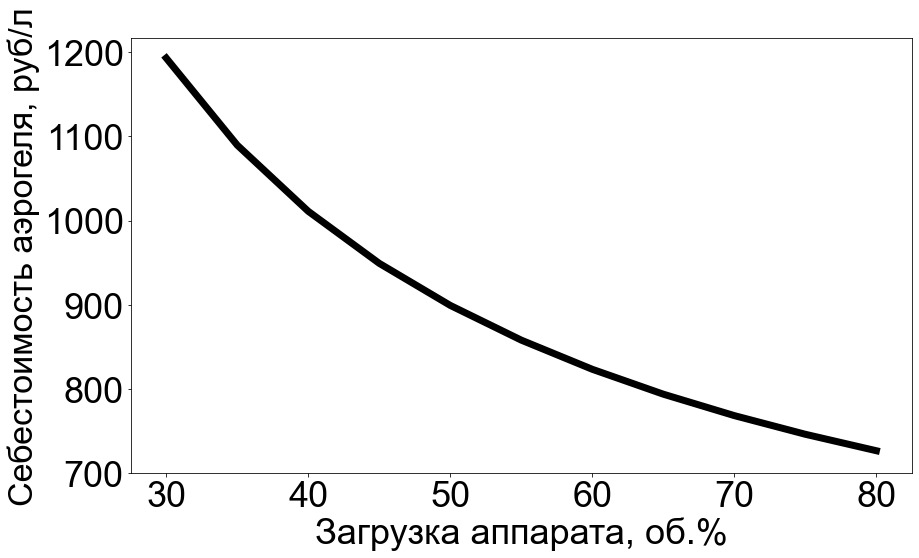

In [29]:

#Себестоимость аэрогеля
fig = plt.figure (figsize = (14, 8))
ax = fig.add_subplot(111)
plt.grid(True)
line2 = plt.plot(load, caerogel, 'black', linewidth = 7, label = 'Себестоимость аэрогеля, руб/л')
ax.set_xlabel("Загрузка аппарата, об.%", fontsize=36)
ax.set_ylabel("Себестоимость аэрогеля, руб/л", fontsize=34)
plt.grid(False)
xticks = ax.get_xticks()
xx = np.arange(30, 81, 10)
xlabels = []
for i in xx:
    xlabels.append('%d' % i)
ax.set_xticks(xx)
ax.set_xticklabels(xlabels, fontsize=36)
yticks = ax.get_yticks()
yy = np.arange(700, 1201, 100)
ylabels = []
for i in yy:
    ylabels.append('%d' % i)
ax.set_yticks(yy)
ax.set_yticklabels(yy, fontsize=36)

In [5]:
#ПОСТРОЕНИЕ 3D ПОВЕРХНОСТЕЙ
prtime = [] #Для записи времени процесса
flow = [] #Для записи расхода диоксида углерода процесса
temp = [] #Для записи температуры процесса
pressure = [] #Для записи давления процесса
prmass = [] #Для записи массы диоксида углерода
initT = 313
endT = 341
stepT = 3
initP = 120
endP = 121
stepP = 20
initF = 30000
endF = 150001
stepF = 5000
Xtemp = []
Yflow = []

for i in range(initT, endT, stepT):
    Xtemp.append(i)

for i in range(initF, endF, stepF):
    Yflow.append(i)

if stepT == 1:
    TstepN = int((endT - initT)//stepT)
else:
    TstepN = int((endT - initT)//stepT+1)
if stepF == 1:
    FstepN = int((endF - initF)//stepF)
else:
    FstepN = int((endF - initF)//stepF+1)

MainTime = np.zeros((TstepN, FstepN)) # создаем двумерный массив размерностью TstepN х PstepN


for i in range(initF, endF, stepF):
    print(i)
    for j in range (initT, endT, stepT):
        p = -0.0049*j**2 + 4.2111*j - 744.56
        d = Fick([70,j,p,1,i])
        MainTime[int((j-initT)/stepT)][int((i-initF)/stepF)] = d

flow, temp = np.meshgrid(Yflow, Xtemp)

30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000


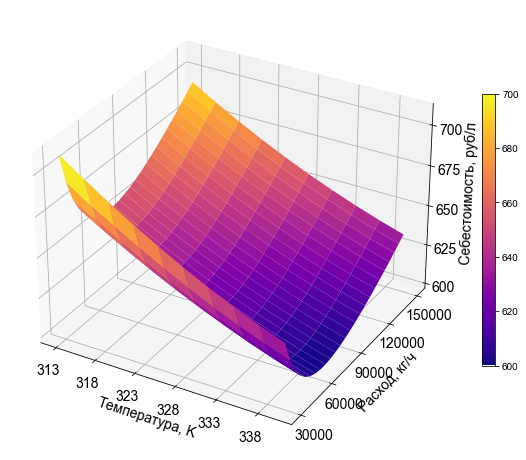

In [8]:
flow, temp = np.meshgrid(Yflow, Xtemp)

#P = -0.0049*T**2 + 4.2111*T - 754.56 # Критические параметры смеси СО2-ИПС для температур 313-353
#MainTime[pressure < -0.0049*temp**2 + 4.2111*temp - 754.56]=np.nan #Обрезаем часть поверхности для параметров ниже критических для смеси диоксид углерода - ИПС
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
surf = ax.plot_surface(temp, flow, MainTime,vmin = 600, vmax = 700, rstride = 1, cstride = 1, cmap = cm.plasma, antialiased=True)
fig.colorbar(surf, drawedges = False, shrink=0.5)
ax.set_xlabel("Температура, K", fontsize=14)
ax.set_ylabel("Расход, кг/ч", fontsize=14)
ax.set_zlabel("Себестоимость, руб/л", fontsize=14)
xticks = ax.get_xticks()
xx = np.arange(initT, endT, 5)
xlabels = []
for i in xx:
    xlabels.append('%d' % i)
ax.set_xticks(xx)
ax.set_xticklabels(xlabels, fontsize=14)

yticks = ax.get_yticks()
yy = np.arange(initF, endF, 30000)
ylabels = []
for i in yy:
    ylabels.append('%d' % i)
ax.set_yticks(yy)
ax.set_yticklabels(yy, fontsize=14)

zticks = ax.get_zticks()
zz = np.arange(600,705, 25)
zlabels = []
for i in zz:
    zlabels.append('%d' % i)
ax.set_zticks(zz)
ax.set_zticklabels(zz, fontsize=14)
plt.show()

In [13]:
#ПОСТРОЕНИЕ 3D ПОВЕРХНОСТЕЙ
prtime = [] #Для записи времени процесса
flow = [] #Для записи расхода диоксида углерода процесса
temp = [] #Для записи температуры процесса
pressure = [] #Для записи давления процесса
prmass = [] #Для записи массы диоксида углерода
loadapp = [] #Для записи загрузки аппарата
initT = 313
endT = 341
stepT = 3
initP = 120
endP = 201
stepP = 5
initF = 30000
endF = 150001
stepF = 5000
initL = 30
endL = 81
stepL = 5
Xpress = []
Yload = []

for i in range(initP, endP, stepP):
    Xpress.append(i)

for i in range(initL, endL, stepL):
    Yload.append(i)

if stepT == 1:
    PstepN = int((endP - initP)//stepP)
else:
    PstepN = int((endP - initP)//stepP+1)
if stepL == 1:
    LstepN = int((endL - initL)//stepL)
else:
    LstepN = int((endL - initL)//stepL+1)

MainTime = np.zeros((PstepN, LstepN)) # создаем двумерный массив 


for i in range(initL, endL, stepL):
    print(i)
    for j in range (initP, endP, stepP):
        d = Fick([i,313,j,1,150000])
        MainTime[int((j-initP)/stepP)][int((i-initL)/stepL)] = d

loadapp, pressure = np.meshgrid(Yload, Xpress)

30
35
40
45
50
55
60
65
70
75
80


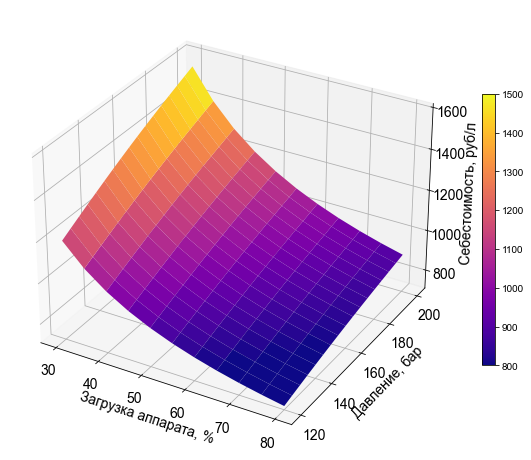

In [22]:

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
surf = ax.plot_surface(loadapp, pressure, MainTime ,vmin = 800, vmax = 1500, rstride = 1, cstride = 1, cmap = cm.plasma, antialiased=True)
fig.colorbar(surf, drawedges = False, shrink=0.5)
ax.set_xlabel("Загрузка аппарата, %", fontsize=14)
ax.set_ylabel("Давление, бар", fontsize=14)
ax.set_zlabel("Себестоимость, руб/л", fontsize=14)
xticks = ax.get_xticks()
xx = np.arange(initL, endL, 10)
xlabels = []
for i in xx:
    xlabels.append('%d' % i)
ax.set_xticks(xx)
ax.set_xticklabels(xlabels, fontsize=14)

yticks = ax.get_yticks()
yy = np.arange(initP, endP, 20)
ylabels = []
for i in yy:
    ylabels.append('%d' % i)
ax.set_yticks(yy)
ax.set_yticklabels(yy, fontsize=14)

zticks = ax.get_zticks()
zz = np.arange(800,1605, 200)
zlabels = []
for i in zz:
    zlabels.append('%d' % i)
ax.set_zticks(zz)
ax.set_zticklabels(zz, fontsize=14)
plt.show()